In [2]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

class Network(object):
    
    def __init__(self, sizes):
        
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs for later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward (self, a):
        
        """Return the output of the network if "a" is input. The np.dot() 
        function computes the matrix multiplication between the weight and input
        matrices for each set of layers. When used with numpy arrays, the '+'
        operator performs matrix addition."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters specify the number 
        of epochs, size of each mini-batch, and the learning rate.  
        If "test_data" is provided then the network will be evaluated 
        against the test data after each epoch, and partial progress 
        printed out.  This is useful for tracking progress, but slows
        things down substantially."""
        
        # create an empty array to store the accuracy results from each epoch
        results = []

        n = len(training_data)
        
        if test_data: 
            n_test = len(test_data)
            
        # this is the code for one training step, done once for each epoch
        for j in xrange(epochs):
            
            # before each epoch, the data is randomly shuffled
            random.shuffle(training_data)
            
            # training data is broken up into individual mini-batches
            mini_batches = [ training_data[k:k+mini_batch_size] 
                            for k in xrange(0, n, mini_batch_size) ]
            
            # then each mini-batch is used to update the parameters of the 
            # network using backpropagation and the specified learning rate
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            # if a test data set is provided, the accuracy results 
            # are displayed and stored in the 'results' array
            if test_data:
                num_correct = self.evaluate(test_data)
                accuracy = "%.2f" % (100 * (float(num_correct) / n_test))
                print "Epoch", j, ":", num_correct, "/", n_test, "-", accuracy, "% acc"
                results.append(accuracy)
            else:
                print "Epoch", j, "complete"
                
        return results
    
    def update_mini_batch(self, mini_batch, eta):
        
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        """Note that the variable l in the loop below is used a little
        differently to the notation in Chapter 2 of the book.  Here,
        l = 1 means the last layer of neurons, l = 2 is the
        second-last layer, and so on.  It's a renumbering of the
        scheme in the book, used here to take advantage of the fact
        that Python can use negative indices in lists."""
        
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation.
        
        Numpy's argmax() function returns the position of the 
        largest element in an array. We first create a list of 
        predicted value and target value pairs, and then count 
        the number of times those values match to get the total 
        number correct."""
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
    
def sigmoid(z):
#     The sigmoid activation function.
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
#     Derivative of the sigmoid function.
    return sigmoid(z)*(1-sigmoid(z))


     sepal_length  sepal_width  petal_length  petal_width     species
71            6.1          2.8           4.0          1.3  versicolor
13            4.3          3.0           1.1          0.1      setosa
59            5.2          2.7           3.9          1.4  versicolor
4             5.0          3.6           1.4          0.2      setosa
120           6.9          3.2           5.7          2.3   virginica
[[ 0.7721519   0.63636364  0.57971014  0.52      ]
 [ 0.5443038   0.68181818  0.15942029  0.04      ]
 [ 0.65822785  0.61363636  0.56521739  0.56      ]
 [ 0.63291139  0.81818182  0.20289855  0.08      ]
 [ 0.87341772  0.72727273  0.82608696  0.92      ]
 [ 0.97468354  0.59090909  1.          0.92      ]
 [ 0.69620253  0.95454545  0.20289855  0.08      ]
 [ 0.69620253  0.79545455  0.1884058   0.08      ]
 [ 0.64556962  0.86363636  0.23188406  0.08      ]
 [ 0.65822785  0.79545455  0.2173913   0.08      ]
 [ 0.93670886  0.63636364  0.88405797  0.76      ]
 [ 0.56962025  0.52

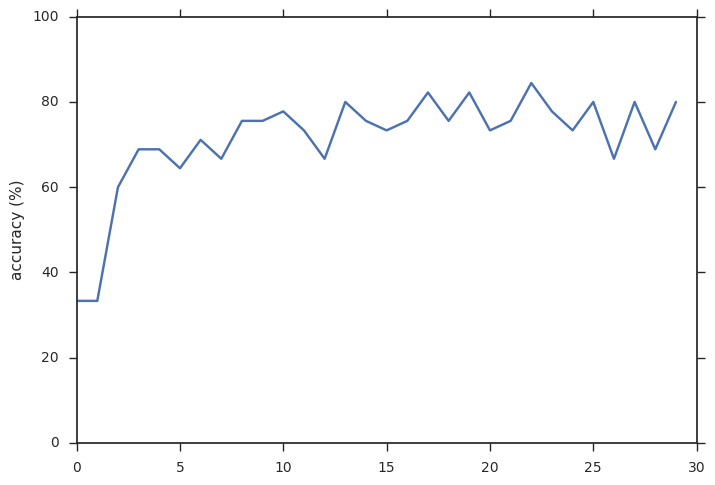

In [55]:
iris_data = sns.load_dataset("iris")

# randomly shuffle data
iris_data = shuffle(iris_data)

# print first 5 data points
print iris_data[:5]


# create pairplot of iris data
g = sns.pairplot(iris_data, hue="species")

# convert iris data to numpy format
iris_array = iris_data.as_matrix()

# split data into feature and target sets
X = iris_array[:, :4].astype(float)
y = iris_array[:, -1]


# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)
print X

# convert the textual category data to integer using numpy's unique() function
_, y = np.unique(y, return_inverse=True)

# convert the list of targets to a vertical matrix with the dimensions [1 x number of samples]
# this is necessary for later computation
y = y.reshape(-1,1)

# combine feature and target data into a new python array
data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))

# split data into training and test sets
trainingSplit = int(.7 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# create an instance of the one-hot encoding function from the sci-kit learn library
enc = OneHotEncoder()

# use the function to figure out how many categories exist in the data
enc.fit(y)

# convert only the target data in the training set to one-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]

# define the network
net = Network([4, 32, 3])

# train the network using SGD, and output the results
results = net.SGD(training_data, 30, 10, 0.2, test_data=test_data)

# visualize the results
plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()

[[  1.36400000e+01   3.10000000e+00   2.56000000e+00 ...,   9.60000000e-01
    3.36000000e+00   8.45000000e+02]
 [  1.47500000e+01   1.73000000e+00   2.39000000e+00 ...,   1.25000000e+00
    2.73000000e+00   1.15000000e+03]
 [  1.42200000e+01   1.70000000e+00   2.30000000e+00 ...,   9.40000000e-01
    3.31000000e+00   9.70000000e+02]
 ..., 
 [  1.25200000e+01   2.43000000e+00   2.17000000e+00 ...,   9.00000000e-01
    2.78000000e+00   3.25000000e+02]
 [  1.34000000e+01   3.91000000e+00   2.48000000e+00 ...,   7.00000000e-01
    1.56000000e+00   7.50000000e+02]
 [  1.37100000e+01   5.65000000e+00   2.45000000e+00 ...,   6.40000000e-01
    1.74000000e+00   7.40000000e+02]]
[ 0.  0.  0.  1.  1.  1.  1.  1.  1.  2.  1.  2.  1.  1.  0.  2.  1.  0.
  1.  2.  0.  2.  2.  1.  0.  1.  0.  2.  1.  1.  0.  0.  1.  0.  1.  0.
  2.  0.  1.  0.  1.  1.  1.  1.  1.  2.  1.  1.  0.  2.  0.  0.  0.  0.
  1.  1.  2.  1.  2.  1.  1.  2.  0.  1.  2.  2.  0.  0.  2.  2.  0.  0.
  0.  0.  0.  1.  2.  1.  1.

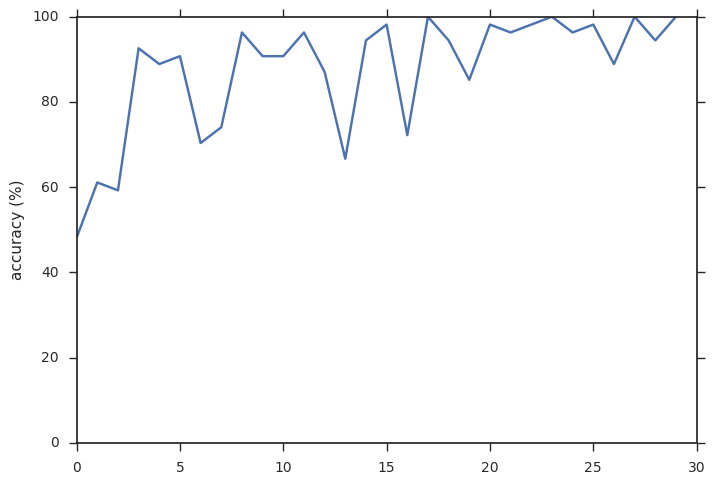

In [63]:
wine_data = np.loadtxt(open("./data/wine.csv","rb"),delimiter=",")

wine_data = shuffle(wine_data)
# g = sns.pairplot(wine_data, hue="species")

X = wine_data[:,1:]
y = wine_data[:, 0] - 1

print X
print y

X = X / X.max(axis=0)
y = y.reshape(-1,1)

data = []
for i in range(X.shape[0]):
    data.append(tuple([X[i].reshape(-1,1), y[i][0]]))

# split data into training and test sets
trainingSplit = int(.7 * len(data))
training_data = data[:trainingSplit]
test_data = data[trainingSplit:]

# create an instance of the one-hot encoding function from the sci-kit learn library
enc = OneHotEncoder()

# use the function to figure out how many categories exist in the data
enc.fit(y)

# convert only the target data in the training set to one-hot encoding
training_data = [[_x, enc.transform(_y.reshape(-1,1)).toarray().reshape(-1,1)] for _x, _y in training_data]

# define the network
net = Network([13, 50, 3])

# train the network using SGD, and output the results
results = net.SGD(training_data, 30, 10, 1.0, test_data=test_data)

# visualize the results
plt.plot(results)
plt.ylabel('accuracy (%)')
plt.ylim([0,100.0])
plt.show()